In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Randomly choose TB images to match Normal count**

In [ ]:
import os

BASE_DIR    = "/content/drive/MyDrive/TB_detection_project"
DATASET_DIR = f"{BASE_DIR}/Dataset of Tuberculosis Chest X-rays Images"

TB_DIR      = f"{DATASET_DIR}/TB Chest X-rays"
NORMAL_DIR  = f"{DATASET_DIR}/Normal Chest X-rays"

print("TB_DIR exists:", os.path.isdir(TB_DIR))
print("NORMAL_DIR exists:", os.path.isdir(NORMAL_DIR))


TB_DIR exists: True
NORMAL_DIR exists: True


In [ ]:
import os

BASE_DIR = "/content/drive/MyDrive/TB_detection_project"
print(os.listdir(BASE_DIR))

DATASET_DIR = f"{BASE_DIR}/Dataset of Tuberculosis Chest X-rays Images"
print(os.listdir(DATASET_DIR))

['Dataset of Tuberculosis Chest X-rays Images', 'tb_detection app.ipynb', 'balanced_dataset', 'processed_dataset', 'processed_train', 'processed_val', 'processed_test', 'tb_resnet50_model.pth', 'tb_detection_project.ipynb']
['Normal Chest X-rays', 'TB Chest X-rays']


In [ ]:
import random, shutil

BALANCED_ROOT = f"{BASE_DIR}/balanced_dataset"
os.makedirs(f"{BALANCED_ROOT}/TB", exist_ok=True)
os.makedirs(f"{BALANCED_ROOT}/Normal", exist_ok=True)

tb_files = [f for f in os.listdir(TB_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))]
normal_files = [f for f in os.listdir(NORMAL_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))]

n_normal = len(normal_files)
random.seed(42)
tb_sample = random.sample(tb_files, n_normal)


In [ ]:
for fname in normal_files:
    shutil.copy2(os.path.join(NORMAL_DIR, fname),
                 os.path.join(BALANCED_ROOT, "Normal", fname))

for fname in tb_sample:
    shutil.copy2(os.path.join(TB_DIR, fname),
                 os.path.join(BALANCED_ROOT, "TB", fname))

print("Balanced TB:", len(os.listdir(f"{BALANCED_ROOT}/TB")))
print("Balanced Normal:", len(os.listdir(f"{BALANCED_ROOT}/Normal")))


**Preprocessed the whole dataset**

In [ ]:
import os
import cv2
import numpy as np

base_dir       = "/content/drive/MyDrive/TB_detection_project"
balanced_root  = f"{base_dir}/balanced_dataset"       # input
processed_root = f"{base_dir}/processed_dataset"      # output

img_size = (224, 224)

os.makedirs(os.path.join(processed_root, "TB"), exist_ok=True)
os.makedirs(os.path.join(processed_root, "Normal"), exist_ok=True)


In [ ]:
for cls in ["TB", "Normal"]:
    src_dir = os.path.join(balanced_root, cls)
    dst_dir = os.path.join(processed_root, cls)

    for fname in os.listdir(src_dir):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        src_path = os.path.join(src_dir, fname)
        dst_path = os.path.join(dst_dir, fname)

        img = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)      # chest X-rays are grayscale
        if img is None:
            continue

        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        img = img.astype("float32") / 255.0                   # standardisation to [0,1]

        img_uint8 = (img * 255).astype("uint8")               # save back as image file
        cv2.imwrite(dst_path, img_uint8)

print("done preprocessing. processed data saved at:", processed_root)

done preprocessing. processed data saved at: /content/drive/MyDrive/TB_detection_project/processed_dataset


**Splitting into the Train, Test and Validate set**

In [ ]:
import os
import random
import shutil

base_dir       = "/content/drive/MyDrive/TB_detection_project"
processed_root = f"{base_dir}/processed_dataset"

train_root = f"{base_dir}/processed_train"
val_root   = f"{base_dir}/processed_val"
test_root  = f"{base_dir}/processed_test"

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15
random_seed = 42

classes = ["TB", "Normal"]

In [ ]:
# create folder structure: separate roots + class subfolders
for cls in classes:
    os.makedirs(os.path.join(train_root, cls), exist_ok=True)
    os.makedirs(os.path.join(val_root, cls), exist_ok=True)
    os.makedirs(os.path.join(test_root, cls), exist_ok=True)

for cls in classes:
    src_dir = os.path.join(processed_root, cls)
    files = [f for f in os.listdir(src_dir)
             if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    random.seed(random_seed)
    random.shuffle(files)

    n_total = len(files)
    n_train = int(train_ratio * n_total)
    n_val   = int(val_ratio * n_total)

    train_files = files[:n_train]
    val_files   = files[n_train:n_train + n_val]
    test_files  = files[n_train + n_val:]

    for fname in train_files:
        shutil.copy2(os.path.join(src_dir, fname),
                     os.path.join(train_root, cls, fname))

    for fname in val_files:
        shutil.copy2(os.path.join(src_dir, fname),
                     os.path.join(val_root, cls, fname))

    for fname in test_files:
        shutil.copy2(os.path.join(src_dir, fname),
                     os.path.join(test_root, cls, fname))

print("train data:", train_root)
print("val data:  ", val_root)
print("test data: ", test_root)

train data: /content/drive/MyDrive/TB_detection_project/processed_train
val data:   /content/drive/MyDrive/TB_detection_project/processed_val
test data:  /content/drive/MyDrive/TB_detection_project/processed_test


EDA (Exploratory Data Analysis)

**Training Set Distribution**

Image counts by class:
  TB: 359
  Normal: 359
  Total: 718


/tmp/ipython-input-1676532056.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["TB", "Normal"], y=[tb_count, normal_count], palette="viridis")


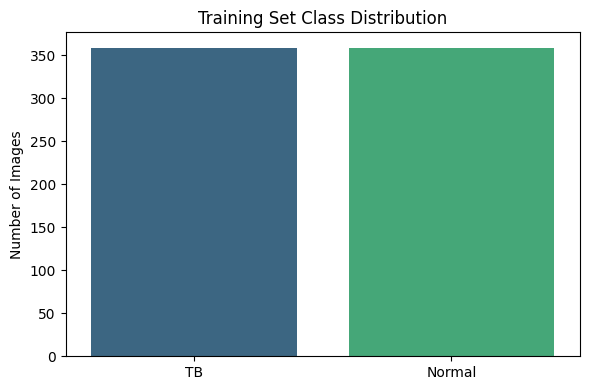

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = "/content/drive/MyDrive/TB_detection_project"
train_root = f"{base_dir}/processed_train"

train_tb_folder     = os.path.join(train_root, "TB")
train_normal_folder = os.path.join(train_root, "Normal")

tb_images_list = [f for f in os.listdir(train_tb_folder)
                  if f.lower().endswith((".jpg", ".jpeg", ".png"))]
normal_images_list = [f for f in os.listdir(train_normal_folder)
                      if f.lower().endswith((".jpg", ".jpeg", ".png"))]

tb_count = len(tb_images_list)
normal_count = len(normal_images_list)

print("Image counts by class:")
print(f"  TB: {tb_count}")
print(f"  Normal: {normal_count}")
print(f"  Total: {tb_count + normal_count}")

plt.figure(figsize=(6, 4))
sns.barplot(x=["TB", "Normal"], y=[tb_count, normal_count], palette="viridis")
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


**Summary Statistics and Pixel Intensity Ditribution**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_all_images(folder):
    imgs = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, f)
                img = cv2.imread(path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                imgs.append(img)
    return np.stack(imgs) if imgs else np.empty((0, 224, 224, 3))

base_dir   = "/content/drive/MyDrive/TB_detection_project"
train_root = f"{base_dir}/processed_train"

tb_images     = load_all_images(os.path.join(train_root, "TB"))
normal_images = load_all_images(os.path.join(train_root, "Normal"))

tb_pixels = tb_images.reshape(-1, 3)
normal_pixels = normal_images.reshape(-1, 3)

channels = ['Red', 'Green', 'Blue']


Red: min=0.000, max=255.000, mean=137.039, std=58.562
Green: min=0.000, max=255.000, mean=137.039, std=58.562
Blue: min=0.000, max=255.000, mean=137.039, std=58.562

Normal image pixel stats:
Red: min=0.000, max=255.000, mean=132.736, std=50.581
Green: min=0.000, max=255.000, mean=132.736, std=50.581
Blue: min=0.000, max=255.000, mean=132.736, std=50.581


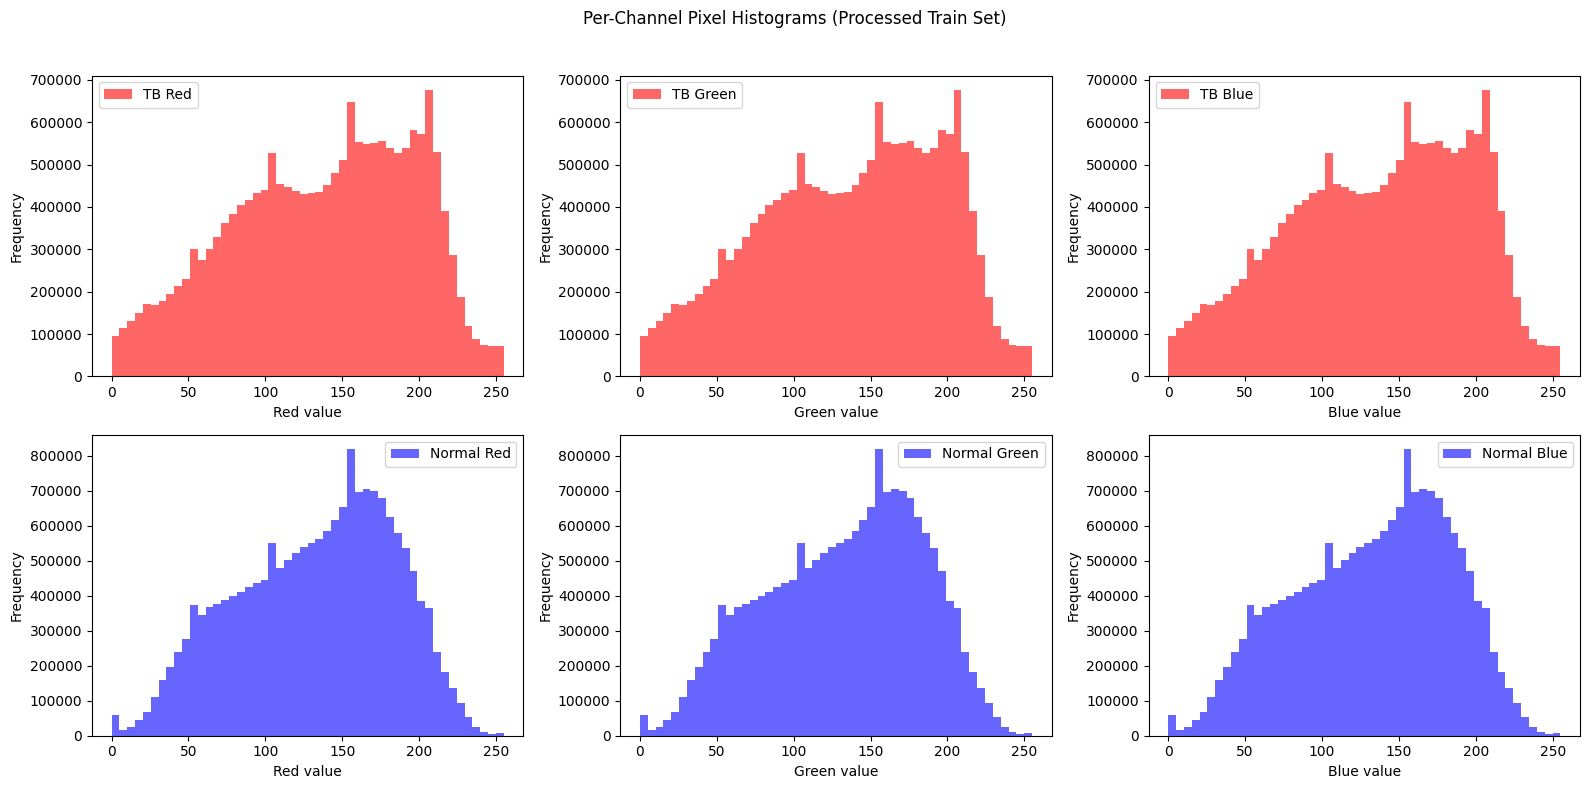

In [ ]:
print("TB image pixel stats:")
for i, c in enumerate(channels):
    print(f"{c}: min={tb_pixels[:,i].min():.3f}, max={tb_pixels[:,i].max():.3f}, "
          f"mean={tb_pixels[:,i].mean():.3f}, std={tb_pixels[:,i].std():.3f}")

print("\nNormal image pixel stats:")
for i, c in enumerate(channels):
    print(f"{c}: min={normal_pixels[:,i].min():.3f}, max={normal_pixels[:,i].max():.3f}, "
          f"mean={normal_pixels[:,i].mean():.3f}, std={normal_pixels[:,i].std():.3f}")

plt.figure(figsize=(16, 8))
for i, c in enumerate(channels):
    plt.subplot(2, 3, i+1)
    plt.hist(tb_pixels[:, i], bins=50, color='red', alpha=0.6, label=f'TB {c}')
    plt.xlabel(f"{c} value")
    plt.ylabel("Frequency")
    plt.legend()

    plt.subplot(2, 3, i+4)
    plt.hist(normal_pixels[:, i], bins=50, color='blue', alpha=0.6, label=f'Normal {c}')
    plt.xlabel(f"{c} value")
    plt.ylabel("Frequency")
    plt.legend()

plt.suptitle("Per-Channel Pixel Histograms (Processed Train Set)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Image Dimensions and Visual Samples,**
**Display Random Samples**

In [ ]:
def load_images(folder):
    imgs = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                img = cv2.imread(os.path.join(root, f))
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                imgs.append(img)
    return np.stack(imgs) if imgs else np.empty((0, 224, 224, 3))

# paths for each class (processed train split)
base_dir   = "/content/drive/MyDrive/TB_detection_project"
train_root = f"{base_dir}/processed_train"

tb_images     = load_images(os.path.join(train_root, "TB"))
normal_images = load_images(os.path.join(train_root, "Normal"))

print(f"TB images: {tb_images.shape}")
print(f"Normal images: {normal_images.shape}")

if tb_images.shape[1:] == normal_images.shape[1:]:
    print("All cleaned images have consistent shape:", tb_images.shape[1:])

TB images: (359, 224, 224, 3)
Normal images: (359, 224, 224, 3)
All cleaned images have consistent shape: (224, 224, 3)


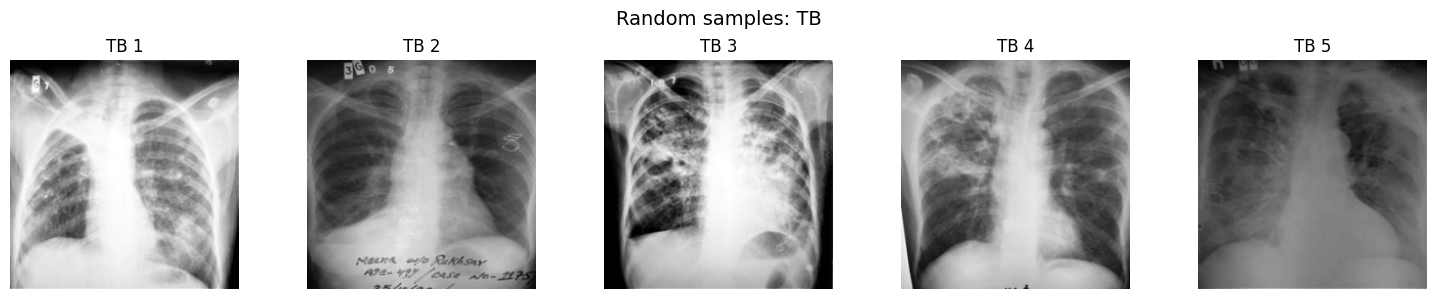

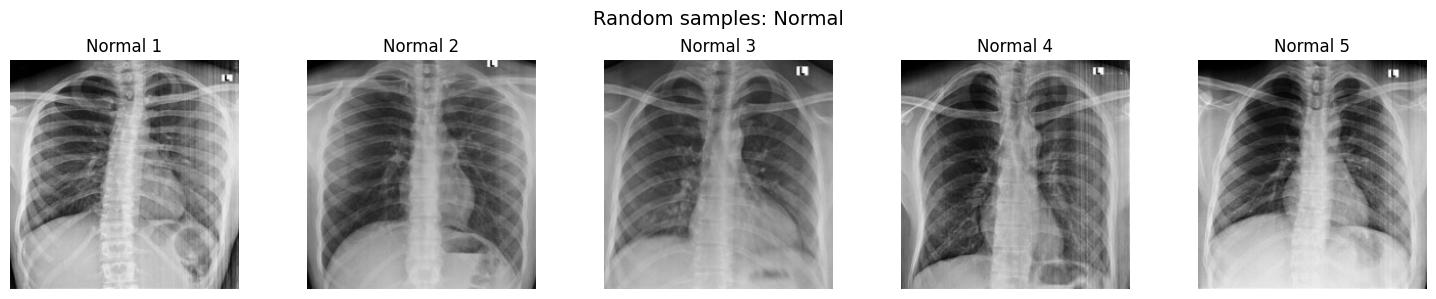

In [ ]:
# visualize clean samples side-by-side
def show_samples(image_stack, label, num_samples=5):
    if image_stack.shape[0] == 0:
        print(f"No images for {label}")
        return
    idxs = np.random.choice(image_stack.shape[0],
                            min(num_samples, image_stack.shape[0]),
                            replace=False)
    plt.figure(figsize=(3 * num_samples, 3))
    for i, idx in enumerate(idxs):
        img_norm = image_stack[idx]
        img_disp = np.clip(img_norm, 0, 255).astype(np.uint8)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_disp)
        plt.axis("off")
        plt.title(f"{label} {i+1}", fontsize=12)
    plt.suptitle(f"Random samples: {label}", fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples(tb_images, "TB")
show_samples(normal_images, "Normal")

**MODELS**

RESNet50 Model with Training loss

In [ ]:
import os
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_dir   = "/content/drive/MyDrive/TB_detection_project"
train_root = f"{base_dir}/processed_train"
weights_path = f"{base_dir}/tb_resnet50_model.pth"


In [ ]:
img_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225])
])

class xray_dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        for label, cls in enumerate(["Normal", "TB"]):
            cls_dir = os.path.join(root_dir, cls)
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".png",".jpg",".jpeg")):
                    self.samples.append((os.path.join(cls_dir, f), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor([label], dtype=torch.float32)

train_ds = xray_dataset(train_root, img_tfms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)


In [ ]:
# temporary
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 94.9MB/s]


In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_ds)
    print(f"epoch {epoch+1}/{epochs}  train_loss={epoch_loss:.4f}")

torch.save(model.state_dict(), weights_path)
print("saved weights to:", weights_path)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


epoch 1/5  train_loss=0.1040
epoch 2/5  train_loss=0.0151
epoch 3/5  train_loss=0.0026
epoch 4/5  train_loss=0.0009
epoch 5/5  train_loss=0.0019
saved weights to: /content/drive/MyDrive/TB_detection_project/tb_resnet50_model.pth


In [ ]:
from torch.utils.data import DataLoader

# --- validation loss after training ---
val_root = f"{base_dir}/processed_val"

val_ds = xray_dataset(val_root, img_tfms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

# load best weights
state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

val_loss_sum, n_samples = 0.0, 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        batch_size = labels.size(0)
        val_loss_sum += loss.item() * batch_size
        n_samples    += batch_size

val_loss = val_loss_sum / n_samples
print(f"validation loss: {val_loss:.4f}")

validation loss: 0.0012


**Model = VGG16**

In [ ]:
# dataset and loader (same as before)
train_ds = xray_dataset(train_root, img_tfms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)

# VGG16 model for binary output
model2 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
in_features = model2.classifier[-1].in_features
model2.classifier[-1] = nn.Linear(in_features, 1)
model2 = model2.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-4)
weights_path = f"{base_dir}/tb_vgg16_model.pth"

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 107MB/s] 


In [ ]:
epochs = 5

for epoch in range(epochs):
    model2.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_ds)
    print(f"epoch {epoch+1}/{epochs}  train_loss={epoch_loss:.4f}")

torch.save(model2.state_dict(), weights_path)
print("saved VGG16 weights to:", weights_path)

epoch 1/5  train_loss=0.1506
epoch 2/5  train_loss=0.0294
epoch 3/5  train_loss=0.0232
epoch 4/5  train_loss=0.0004
epoch 5/5  train_loss=0.0000
saved VGG16 weights to: /content/drive/MyDrive/TB_detection_project/tb_vgg16_model.pth


In [ ]:
base_dir     = "/content/drive/MyDrive/TB_detection_project"
val_root     = f"{base_dir}/processed_val"
vgg_weights  = f"{base_dir}/tb_vgg16_model.pth"

# dataset and loader
val_ds = xray_dataset(val_root, img_tfms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

# load trained VGG16 weights
state_dict = torch.load(vgg_weights, map_location=device)
model2.load_state_dict(state_dict)
model2.to(device)
model2.eval()

val_loss_sum, n_samples = 0.0, 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model2(imgs)
        loss = criterion(outputs, labels)

        batch_size = labels.size(0)
        val_loss_sum += loss.item() * batch_size
        n_samples    += batch_size

val_loss = val_loss_sum / n_samples
print(f"VGG16 validation loss: {val_loss:.4f}")

VGG16 validation loss: 0.0000


**Model = EfficientNetB0**

In [ ]:
# EfficientNet-B0 model for binary classification
model3 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model3.classifier[-1].in_features
model3.classifier[-1] = nn.Linear(in_features, 1)      # single logit
model3 = model3.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model3.parameters(), lr=1e-4)
weights_path = f"{base_dir}/tb_efficientnet_b0_model.pth"

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


In [ ]:
epochs = 5

for epoch in range(epochs):
    model3.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model3(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_ds)
    print(f"epoch {epoch+1}/{epochs}  train_loss={epoch_loss:.4f}")

torch.save(model3.state_dict(), weights_path)
print("saved EfficientNet-B0 weights to:", weights_path)

epoch 1/5  train_loss=0.4105
epoch 2/5  train_loss=0.0917
epoch 3/5  train_loss=0.0293
epoch 4/5  train_loss=0.0234
epoch 5/5  train_loss=0.0126
saved EfficientNet-B0 weights to: /content/drive/MyDrive/TB_detection_project/tb_efficientnet_b0_model.pth


Validation loss

In [ ]:
val_root    = f"{base_dir}/processed_val"
eff_weights = f"{base_dir}/tb_efficientnet_b0_model.pth"

val_ds = xray_dataset(val_root, img_tfms)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

state_dict = torch.load(eff_weights, map_location=device)
model3.load_state_dict(state_dict)
model3.to(device)
model3.eval()

val_loss_sum, n_samples = 0.0, 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model3(imgs)
        loss = criterion(outputs, labels)

        batch_size = labels.size(0)
        val_loss_sum += loss.item() * batch_size
        n_samples    += batch_size

val_loss = val_loss_sum / n_samples
print(f"EfficientNet-B0 validation loss: {val_loss:.4f}")

EfficientNet-B0 validation loss: 0.0080


VGG16 is best: it reaches essentially zero training loss and zero validation loss, lower than ResNet50 (≈0.001–0.002) and much lower than EfficientNet (≈0.008–0.013).

**Evaluation metrics score for Test set**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

base_dir   = "/content/drive/MyDrive/TB_detection_project"
test_root  = f"{base_dir}/processed_test"
best_weights = f"{base_dir}/tb_vgg16_model.pth"

# dataset + loader
test_ds = xray_dataset(test_root, img_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# load best model weights
state_dict = torch.load(best_weights, map_location=device)
model2.load_state_dict(state_dict)
model2.to(device)
model2.eval()

all_labels = []
all_preds  = []

In [ ]:
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs   = imgs.to(device)
        labels = labels.to(device)

        logits = model2(imgs)
        probs  = torch.sigmoid(logits)
        preds  = (probs >= 0.5).int()

        all_labels.extend(labels.cpu().numpy().ravel())
        all_preds.extend(preds.cpu().numpy().ravel())

acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)

print(f"Test accuracy : {acc:.4f}")
print(f"Test precision: {prec:.4f}")
print(f"Test recall   : {rec:.4f}")
print(f"Test F1-score : {f1:.4f}")

Test accuracy : 1.0000
Test precision: 1.0000
Test recall   : 1.0000
Test F1-score : 1.0000
